## Regression with BIWI head pose dataset

All previous exercises were focusing on classification dataset.
Now, we will work on regression images, predicting the position of head ( hence it isn't either class 1, or class 2 but it is a location in the image

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import * # import necessary libraries

## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE) # untar the images

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg' # img file name 

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt' # return the textfile name with the specific image's head position data

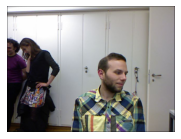

In [7]:
img = open_image(path/fname) # open image and display
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr ## get the position of the head 

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):   ## user defined function that calculates the coordinates 
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [10]:
get_ctr(fname) ## get the center of head 

tensor([263.9104, 428.5814])

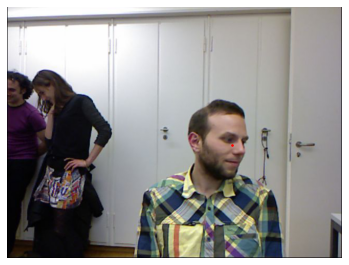

In [11]:
ctr = get_ctr(fname) ## and plot it on the image with a red dot 
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13') ## random person to validate the data 
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160)) ## tfm_y should be true since the dot should flip with the image
        .databunch().normalize(imagenet_stats)
       )

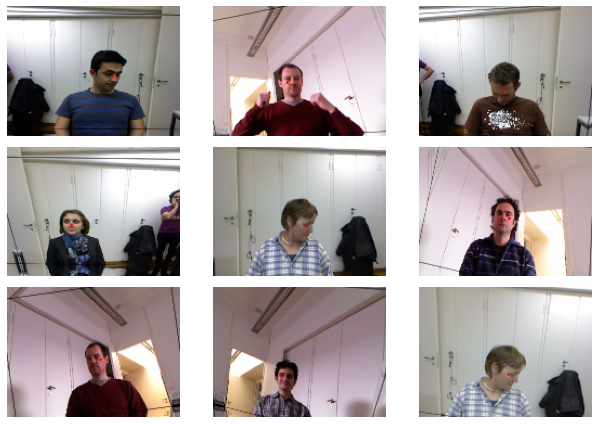

In [13]:
data.show_batch(3, figsize=(9,6)) ## display data set 

## Train model

In [14]:
learn = cnn_learner(data, models.resnet34) ## create learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


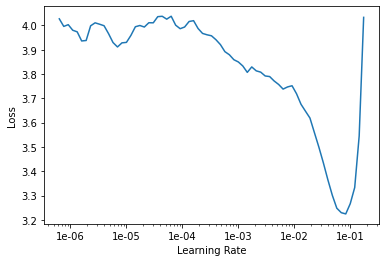

In [15]:
learn.lr_find()
learn.recorder.plot() ## plot the learning rate

In [0]:
lr = 2e-2 ## use the most effective 

In [17]:
learn.fit_one_cycle(5, slice(lr)) ## train the model we can see the valid_loss is already very small, meaning it's very accurate

epoch,train_loss,valid_loss,time
0,0.123146,0.003954,02:55
1,0.042168,0.003257,02:55
2,0.014338,0.003638,02:53
3,0.008692,0.001288,02:53
4,0.006456,0.003428,02:54


In [0]:
learn.save('stage-1') 

In [0]:
learn.load('stage-1');

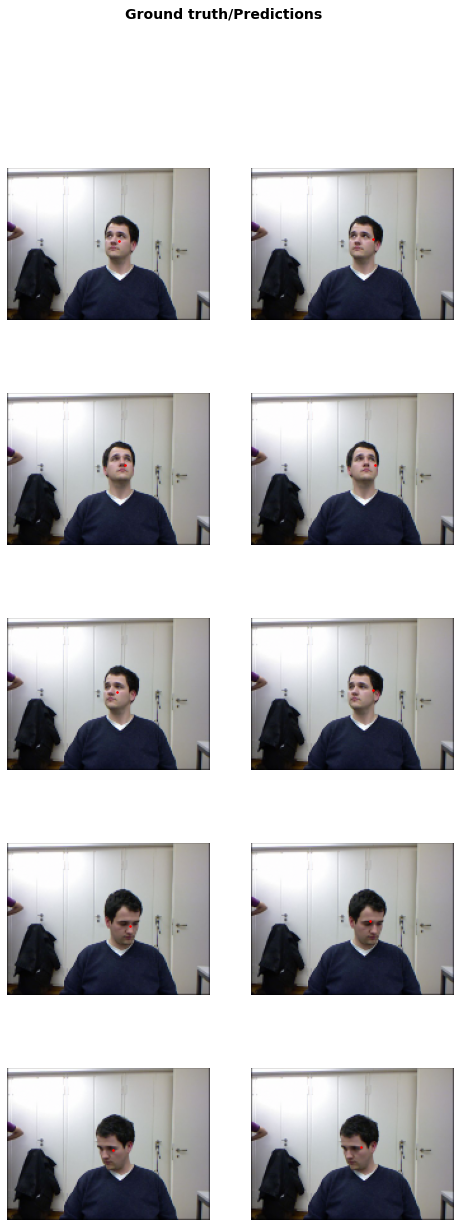

In [20]:
learn.show_results() ## display the results

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.) ## transform the image 

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13') ## create data bunch 
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

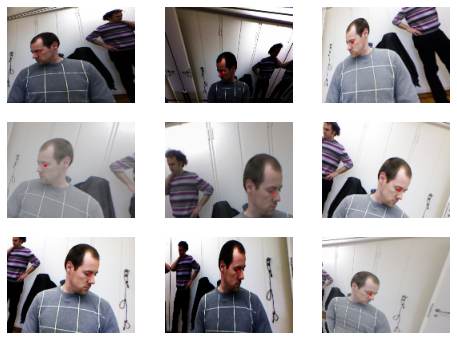

In [22]:
def _plot(i,j,ax):
    x,y = data.train_ds[0] ## plot the center of head
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))